
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from statistics import mean
from scipy.stats import tmean
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence

In [3]:
# loading csv
df_original = pd.read_csv('data/final_dataset.csv').drop("Unnamed: 0", axis=1)

df = df_original.copy()

Columns (53) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
# df_original[df_original["Name"] == "Mohamed-Salah"].groupby(["Pos"]).mean()["Total Points"]

In [5]:
df = df.rename(columns={'GW_x': 'GW'})
# df = df[~(df['position'].isin(['GK']))]
df = df[df['position'].isin(['MID'])]

In [60]:
# df_original[["expected_goals", "xG"]]

In [7]:
df_original["goals_conceded"].unique()

array([ 2.,  1.,  0., nan,  3.,  4.,  5.,  7.,  6.,  8.,  9.])

In [8]:
# df_original.columns.to_list()

In [9]:
df["position"].unique()

array(['FWD'], dtype=object)

In [10]:
df.shape

(2589, 117)

In [11]:
to_predict = ["total_points"]
features1 = ["Was Home", "Team rating", "Opp rating", 
             # 'ScoreForLast5', 'ScoreAgainstLast5',
             ]
features_to_roll = [
                "Min", "Start", # time played
                'Gls', 'Sh', 'SoT', # Goals
                'Ast', # Assists
                'CrdY', 'CrdR', # Cards
                "xG", 'xAG', # Expected
                'CS', # Defence
                'Team Score', 'Opp Score', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "Succ", "PKwon",
                'bonus', 'bps', # Bonus
                'influence', 'creativity', 'threat', 'ict_index', # ICT
                "total_points" # FPL points
            ]
# features_to_roll = "Min"
info = ["Name", "GW", "Season", "Squad", "Opponent", "Was Home", "Team rating", "Opp rating", "position"]

In [12]:
# df[features_to_roll + info].isnull().sum(axis=0).sort_values(ascending=False).head(30)

# Preparing dataset

In [13]:
def calculate_xg_points(row):
    if row["position"] == "GK":
        return row["xG"] * 6
    elif row["position"] == "DEF":
        return row["xG"] * 6
    elif row["position"] == "MID":
        return row["xG"] * 5
    elif row["position"] == "FWD":
        return row["xG"] * 4
    else:
        return row["xG"] * 5

df["xGPoints"] = df.apply(calculate_xg_points, axis=1)

In [14]:
def calculate_cs_points(row):
    if row["position"] == "GK":
        return row["xG"] * 4
    elif row["position"] == "DEF":
        return row["xG"] * 4
    elif row["position"] == "MID":
        return row["xG"] * 1
    elif row["position"] == "FWD":
        return row["xG"] * 0
    else:
        return row["xG"] * 1

df["CSPoints"] = df.apply(calculate_cs_points, axis=1)

In [15]:
df.shape

(2589, 119)

In [16]:
def add_rolling_features(df, features1, features_to_roll):
    rolling_gameweeks = [2, 5]
    features = features1
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        form_means = form_means.fillna(method='bfill')
        
        
        
        
        
        
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        
        print(form_means.columns)
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df, form_means], axis=1)
        
        
    return df, features

In [17]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)
        # df = df.drop(c, axis=1)
        print("OHE", ohe_c.columns)

        features += ohe_c.columns.tolist()
        
    return df, features

In [18]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 2,
        'Y*': 1,
        'N': 0,
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [19]:
df = df.reset_index()

In [20]:
# df.head(30)

In [21]:
df, features = add_rolling_features(df, features1, features_to_roll)

Index(['Name_2', 'level_1_2', 'Min_2', 'Gls_2', 'Sh_2', 'SoT_2', 'Ast_2',
       'CrdY_2', 'CrdR_2', 'xG_2', 'xAG_2', 'CS_2', 'Team Score_2',
       'Opp Score_2', 'bonus_2', 'bps_2', 'influence_2', 'creativity_2',
       'threat_2', 'ict_index_2', 'total_points_2'],
      dtype='object')
Index(['Name_5', 'level_1_5', 'Min_5', 'Gls_5', 'Sh_5', 'SoT_5', 'Ast_5',
       'CrdY_5', 'CrdR_5', 'xG_5', 'xAG_5', 'CS_5', 'Team Score_5',
       'Opp Score_5', 'bonus_5', 'bps_5', 'influence_5', 'creativity_5',
       'threat_5', 'ict_index_5', 'total_points_5'],
      dtype='object')


In [22]:
df, features = ohe(df, ["position"], features)

OHE Index(['FWD'], dtype='object')


In [23]:
df = label_encoding(df, "Start")

In [24]:
# dropping unwanted columns
# non_level_columns = [col for col in df.columns if not col.startswith('level')]
features = [col for col in features if not col.startswith('level')]
# df = df[non_level_columns]
df = df[np.unique(features + info + to_predict)]

In [25]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [26]:
# df.head(90).tail(30)

In [27]:
# df.tail(40)

In [28]:
# dropping NaNs
df = df.dropna(axis=0)

In [29]:
df = df.set_index(["Name", "Season", "GW"], drop=False)

In [30]:
df.columns

Index(['Ast_2', 'Ast_5', 'CS_2', 'CS_5', 'CrdR_2', 'CrdR_5', 'CrdY_2',
       'CrdY_5', 'FWD', 'GW', 'Gls_2', 'Gls_5', 'Min_2', 'Min_5', 'Name',
       'Opp Score_2', 'Opp Score_5', 'Opp rating', 'Opponent', 'Season',
       'Sh_2', 'Sh_5', 'SoT_2', 'SoT_5', 'Squad', 'Team Score_2',
       'Team Score_5', 'Team rating', 'Was Home', 'bonus_2', 'bonus_5',
       'bps_2', 'bps_5', 'creativity_2', 'creativity_5', 'ict_index_2',
       'ict_index_5', 'influence_2', 'influence_5', 'position', 'threat_2',
       'threat_5', 'total_points', 'total_points_2', 'total_points_5', 'xAG_2',
       'xAG_5', 'xG_2', 'xG_5'],
      dtype='object')

In [31]:
df.shape

(2589, 49)

# Choosing features and splitting data

In [32]:
GAMEWEEK_TO_PREDICT = 33
SEASON_TO_PREDICT = "2022-23"

In [33]:
# gameweeks 6-14 is training data, gw 15 is test data
X_train = df[((df["Season"] <= SEASON_TO_PREDICT) & (df["GW"] >= 1) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] <= SEASON_TO_PREDICT) & (df["GW"] >= 1) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][to_predict].reset_index(drop=True)

In [34]:
X_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [35]:
X_train.shape, X_test.shape

((2185, 42), (45, 42))

# Model

In [36]:
class HybridModel:
    def __init__(self, models, names, weights):
        self.models = models
        self.model_names = names
        self.weights = weights
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        
    def predict(self, X):
        model_preds = [model.predict(X) for model in self.models]
        preds = []
        for i in range(len(model_preds[0])):
            preds.append(np.mean([x[i] for x in model_preds]))
        return preds
    
    def evaluate(self, X, y):
        ys = [np.expm1(model.predict(X)) for model in self.models]
        y_ensemble = self.predict(X)
        
        rmsle_ys = [(mean_squared_log_error(y, y_model) ** 0.5) for y_model in ys]
        rmsle_ensemble = mean_squared_log_error(y, y_ensemble) ** 0.5
        
        for i in range(0, len(self.models)):
            print(f"RMSLE on {self.model_names[i]} model: {rmsle_ys[i]}")
        print(f"RMSLE on ensemble model: {rmsle_ensemble}")

In [37]:
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

names = [
    "LGBM",
    "XGB",
    "GBR"
]

weights = [
    1,
    1,
    1
]

# hybrid arguments
models = [
    lgbm, 
    xgb, 
    gbr
]

model = HybridModel(models, names, weights)

In [38]:
# model = GradientBoostingRegressor(random_state=42)
# model = LGBMRegressor(random_state=42)
model = XGBRegressor(random_state=42)
# model = RandomForestRegressor()

In [39]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 1.8 s
Wall time: 257 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Evaluation

In [40]:
# make predictions on the test data
predictions = model.predict(X_test)

In [41]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [42]:
df_predictions = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
df_predictions.loc[:, "pred"] = predictions

In [43]:
def get_top_performer_names(df, no_top, no_gws):
    return df.reset_index(drop=True).groupby("Name")["total_points"].mean().groupby("Name").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [44]:
def pairwise_accuracy_topX(model, df, top_x):
    top_performers = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, top_x, 50)))]
    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

In [45]:
def evaluate(model, df, predictions, y_true):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)

In [46]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [47]:
evaluate(model, df, predictions, y_test)

MAE: 1.9888589647081163
MSE: 8.433773662802789
Pairwise accuracy: 0.5414141414141415
Pairwise accuracy @TOP100: 0.5414141414141415
Pairwise accuracy @TOP20: 0.45588235294117646


In [48]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [49]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [50]:
preds = df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False)

In [51]:
preds.head(30)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
23,Harry-Kane,33,2022-23,Tottenham,Manchester Utd,1.0,1820.470093,1854.124756,FWD,11.0,7.730473
35,Ollie-Watkins,33,2022-23,Aston Villa,Fulham,1.0,1812.839722,1725.331177,FWD,2.0,6.979200
1,Alexander-Isak,33,2022-23,Newcastle Utd,Everton,0.0,1871.329468,1675.308716,FWD,1.0,6.137272
34,Odsonne-Edouard,33,2022-23,Crystal Palace,Wolves,0.0,1756.213135,1719.007446,FWD,1.0,6.057947
20,Erling-Haaland,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FWD,14.0,5.887871
10,Danny-Welbeck,33,2022-23,Brighton,Nott'ham Forest,0.0,1832.275635,1625.085327,FWD,1.0,5.590204
14,Diogo-Jota,33,2022-23,Liverpool,West Ham,0.0,1931.599731,1774.066772,FWD,1.0,3.907359
24,Ivan-Toney,33,2022-23,Brentford,Chelsea,0.0,1766.355835,1807.366211,FWD,2.0,3.787186
16,Dominic-Solanke,33,2022-23,Bournemouth,Southampton,0.0,1660.826782,1646.325439,FWD,5.0,3.394029
39,Richarlison,33,2022-23,Tottenham,Manchester Utd,1.0,1820.470093,1854.124756,FWD,2.0,3.338918


In [52]:
preds[preds["Squad"] == "Manchester City"].head(20)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
20,Erling-Haaland,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FWD,14.0,5.887871
28,Julian-Alvarez,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FWD,1.0,0.780339


In [53]:
preds[preds["position"] == "FWD"].head(15)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
23,Harry-Kane,33,2022-23,Tottenham,Manchester Utd,1.0,1820.470093,1854.124756,FWD,11.0,7.730473
35,Ollie-Watkins,33,2022-23,Aston Villa,Fulham,1.0,1812.839722,1725.331177,FWD,2.0,6.979200
1,Alexander-Isak,33,2022-23,Newcastle Utd,Everton,0.0,1871.329468,1675.308716,FWD,1.0,6.137272
34,Odsonne-Edouard,33,2022-23,Crystal Palace,Wolves,0.0,1756.213135,1719.007446,FWD,1.0,6.057947
20,Erling-Haaland,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FWD,14.0,5.887871
10,Danny-Welbeck,33,2022-23,Brighton,Nott'ham Forest,0.0,1832.275635,1625.085327,FWD,1.0,5.590204
14,Diogo-Jota,33,2022-23,Liverpool,West Ham,0.0,1931.599731,1774.066772,FWD,1.0,3.907359
24,Ivan-Toney,33,2022-23,Brentford,Chelsea,0.0,1766.355835,1807.366211,FWD,2.0,3.787186
16,Dominic-Solanke,33,2022-23,Bournemouth,Southampton,0.0,1660.826782,1646.325439,FWD,5.0,3.394029
39,Richarlison,33,2022-23,Tottenham,Manchester Utd,1.0,1820.470093,1854.124756,FWD,2.0,3.338918


# Feature importance and influence

In [54]:
# plot_importance(model)

In [55]:
# fig, ax = plt.subplots(figsize=(16, 8))
# plot_partial_dependence(model, X_train, features, ax=ax)

In [56]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

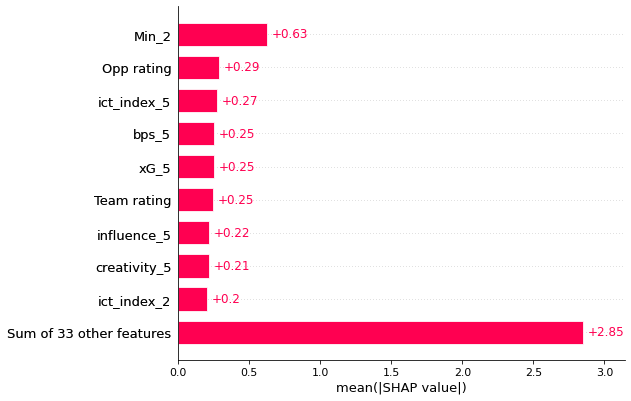

In [57]:
shap.plots.bar(shap_values)

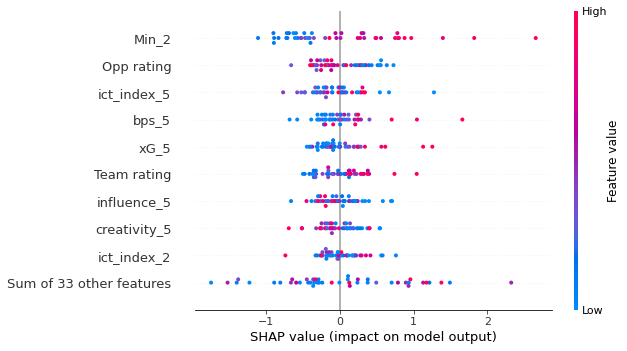

In [58]:
shap.plots.beeswarm(shap_values)

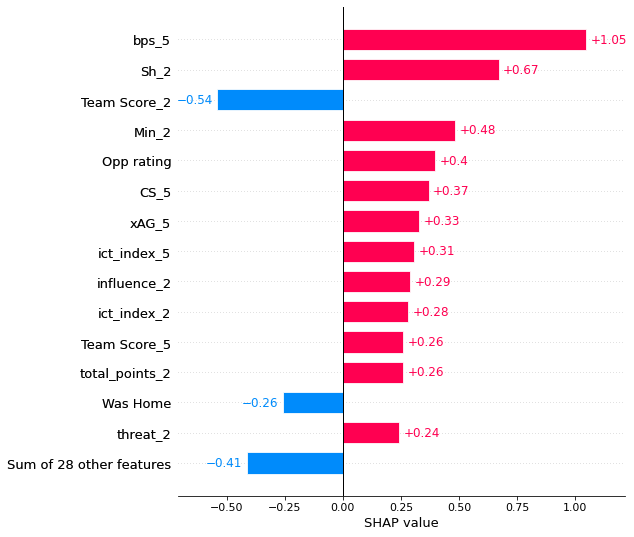

In [59]:
shap.plots.bar(shap_values[1], max_display=15)